In [11]:
from datasets import DatasetDict, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    T5Tokenizer,
    T5ForConditionalGeneration,
    T5Config,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    GenerationConfig,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    EarlyStoppingCallback,
    pipeline,
)
from sentence_transformers import SentenceTransformer
import torch
import numpy as np
import tqdm
import nltk
import csv
import time
import gc
import GPUtil
import evaluate
import pprint
from numba import cuda
import optuna
import wandb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
import wandb
import os
import pickle

In [2]:
wandb.login()
os.environ["WAND_NOTEBOOK_NAME"] = "w266_final_project_models"
os.environ["WANDB_DIR"] = "../models/wandb"
os.environ["WANDB_PROJECT"] = "w266_final_project"

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: garykong. Use `wandb login --relogin` to force relogin


In [3]:
# Random seed for reproducibility
RANDOM_SEED = 42

# Parameters for classification
BATCH_SIZE_EVAL = 32
BATCH_SIZE_TRAIN = 32

# Setting the DEVICE to cuda
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set path for profane word list
PROFANE_WORD_PATH = "../data/raw/en.txt"

# Set path for raw dataset dictionary
RAW_DATASET_PATH = "../data/processed/raw_dataset.pkl"

# Set maximum length for input and output
MAX_INPUT_LENGTH = 64
MAX_OUTPUT_LENGTH = 64

## Load dataset and get lengths

In [4]:
# Load dataset
raw_datasets = DatasetDict.load_from_disk(RAW_DATASET_PATH)
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['source', 'target'],
        num_rows: 10733
    })
    validation: Dataset({
        features: ['source', 'target'],
        num_rows: 1193
    })
    test: Dataset({
        features: ['source', 'target'],
        num_rows: 671
    })
})

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecat

Maximum source length for BART: 38
Maximum target length for BART: 36
Maximum source length for T5: 47
Maximum target length for T5: 43


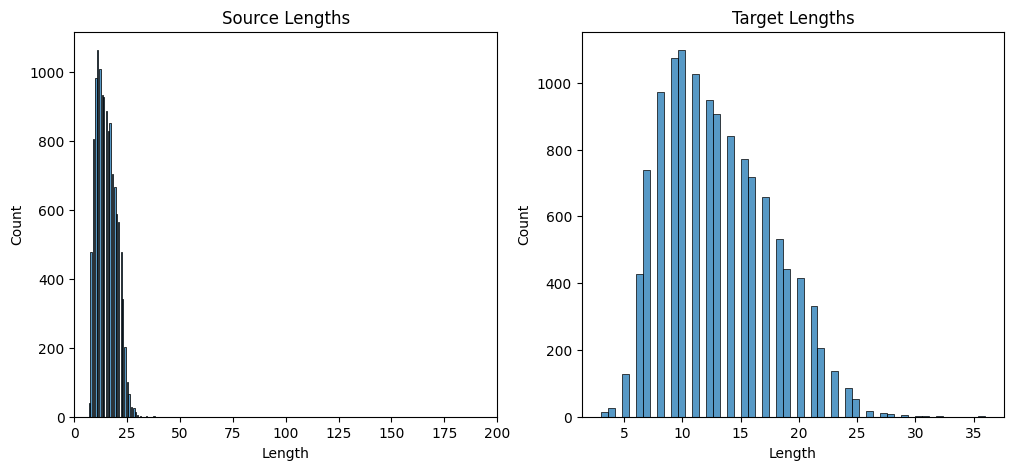

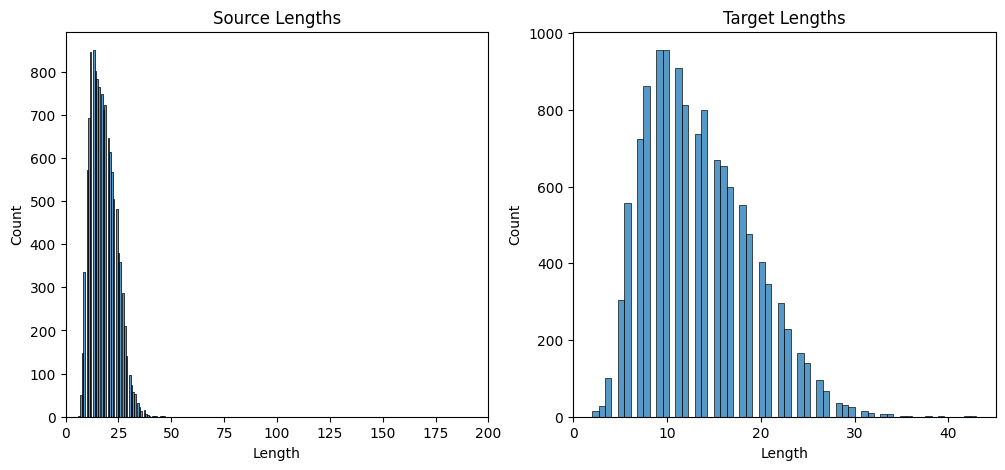

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def get_lengths(raw_datasets, tokenizer):
    """
    Get the lengths of the source and target sequences in the dataset.

    Args:
        raw_datasets (DatasetDict): dictionary containing the raw dataset
        tokenizer (PreTrainedTokenizer): tokenizer to use for encoding the sequences
    
    Returns:
        source_lengths (list): list of lengths of source sequences
        target_lengths (list): list of lengths of target sequences
        max_source_length (int): maximum length of source sequence
        max_target_length (int): maximum length of target sequence
    """
    train_source_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["train"]["source"]]
    val_source_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["validation"]["source"]]
    test_source_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["test"]["source"]]
    source_lengths = train_source_lengths + val_source_lengths + test_source_lengths
    max_source_length = max(source_lengths)

    train_target_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["train"]["target"]]
    val_target_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["validation"]["target"]]
    test_target_lengths = [len(tokenizer(x)["input_ids"]) for x in raw_datasets["test"]["target"]]
    target_lengths = train_target_lengths + val_target_lengths + test_target_lengths
    max_target_length = max(target_lengths)
    
    return source_lengths, target_lengths, max_source_length, max_target_length

def plot_lengths(source_lengths, target_lengths):
    """
    Plot the distribution of lengths of source and target sequences.

    Args:
        source_lengths (list): list of lengths of source sequences
        target_lengths (list): list of lengths of target sequences
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.histplot(source_lengths, ax=axes[0])
    sns.histplot(target_lengths, ax=axes[1])
    axes[0].set_title("Source Lengths")
    axes[1].set_title("Target Lengths")
    axes[0].set_xlabel("Length")
    axes[1].set_xlabel("Length")
    axes[0].set_ylabel("Count")
    axes[1].set_ylabel("Count")
    axes[0].set_xlim(0, 200)

# Get distribution of lengths of source across train, val, and test
bart_source_lengths, bart_target_lengths, bart_max_source_length, bart_max_target_length = get_lengths(raw_datasets, AutoTokenizer.from_pretrained("s-nlp/bart-base-detox"))

# Plot side by side distributions of source and target lengths
plot_lengths(bart_source_lengths, bart_target_lengths)

# Check what lengths would be after tokenization with t5
t5_source_lengths, t5_target_lengths, t5_max_source_length, t5_max_target_length = get_lengths(raw_datasets, AutoTokenizer.from_pretrained("t5-base"))

# Plot side by side distributions of source and target lengths
plot_lengths(t5_source_lengths, t5_target_lengths)

# Print max lengths
print("Maximum source length for BART:", bart_max_source_length)
print("Maximum target length for BART:", bart_max_target_length)
print("Maximum source length for T5:", t5_max_source_length)
print("Maximum target length for T5:", t5_max_target_length)

## Debugging Functions

In [6]:
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Function {func.__name__} took {elapsed_time:.2f} seconds to run.")
    return result

def get_gpu_memory():
    """
    Gets the GPU memory information.
    """
    gpus = GPUtil.getGPUs()
    gpu = gpus[0]
    print(f"Total GPU memory: {gpu.memoryTotal}MB")
    print(f"Free GPU memory: {gpu.memoryFree}MB")
    print(f"Used GPU memory: {gpu.memoryUsed}MB")

def force_clear_GPU_memory():
    """
    Force clears the GPU memory.
    """
    cuda.select_device(0)
    cuda.close()

def cleanup():
    """
    Cleans up the GPU memory.
    """
    gc.collect()
    torch.cuda.empty_cache()

## Evaluation Metrics

In [7]:
# Initialize model variables
model_bleurt = None
model_bertscore = None
model_sacrebleu = None

# Toxicity classifier
tokenizer_toxicity = RobertaTokenizer.from_pretrained("SkolkovoInstitute/roberta_toxicity_classifier")
model_toxicity = RobertaForSequenceClassification.from_pretrained(
    "SkolkovoInstitute/roberta_toxicity_classifier"
)

# Acceptability classifier
tokenizer_acceptability = AutoTokenizer.from_pretrained("iproskurina/tda-bert-en-cola")
model_acceptability = AutoModelForSequenceClassification.from_pretrained("iproskurina/tda-bert-en-cola")

def calc_sacrebleu(refs, preds):
    """
    Calculates the SacreBLEU score.

    Args:
        refs (list): List of reference sentences
        preds (list): List of predicted sentences
    
    Returns:
        results (float): SacreBLEU score
    """
    global model_sacrebleu

    if model_sacrebleu is None:
        model_sacrebleu = evaluate.load("sacrebleu")

    results = model_sacrebleu.compute(predictions=preds, references=refs)["score"]
    results = results/100

    return results

def calc_bert_score(
    refs, preds, model_type="microsoft/deberta-large-mnli", output_mean=True
    ):
    """
    Calculates BERT score per line. Note: https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0 lists the best performing models
    Args:
        refs (list): List of reference sentences.
        y_pred (list): List of predicted sentences.
        model_type (str): Type of BERT model to use.
        output_mean (bool): Whether to output the mean of the scores.

    Returns:
        list of precision, recall, f1 scores.

    """
    global model_bertscore

    if model_bertscore is None:
        model_bertscore = evaluate.load("bertscore")
        
    results = model_bertscore.compute(predictions=preds, references=refs, model_type=model_type)
    precision = np.array(results["precision"])
    recall = np.array(results["recall"])
    f1 = np.array(results["f1"])
    
    if output_mean:
        precision = precision.mean()
        recall = recall.mean()
        f1 = f1.mean()

    return precision, recall, f1

def calc_bleurt(refs, preds, checkpoint="BLEURT-20_D12", output_mean = True):
    """
    Calculates BLEURT score per line.

    Args:
        refs (list): List of reference sentences.
        preds (list): List of predicted sentences.
        output_type (str): Type of output to return. Either 'numpy' or 'list'.

    Returns:
        list/array of BLEURT scores.
    """
    global model_bleurt

    if model_bleurt is None:
        model_bleurt = evaluate.load("bleurt", module_type="metric", checkpoint=checkpoint)

    results = np.array(model_bleurt.compute(predictions=preds, references=refs)["scores"])

    if output_mean:
        results = results.mean()

    return results

def calc_tox_acceptability(
    data,
    tokenizer,
    model,
    output_score=True,
    output_mean=True):
    """
    Calculates toxicity and acceptability scores for a given dataset.

    Args:
        data = list of strings to be evaluated
        tokenizer = tokenizer for the model
        model = model to be used for evaluation
        output_score = whether to output the score or the label
        output_mean = whether to output the mean of the scores or the scores for each sentence
    
    Returns:
        array of toxicity and acceptability scores.
    """
    model = model.to(DEVICE)
    
    inputs = tokenizer(data, return_tensors="pt", padding=True).to(DEVICE)
    with torch.no_grad():
        logits = model(**inputs)["logits"]
        if output_score:
            result = torch.nn.functional.softmax(logits, dim=1)[:, 1]
        else:
            result = logits.argmax(1).data
        result = result.cpu().numpy()

    if output_mean:
        result = result.mean()
        
    return result

def evaluate_metrics(
    refs,
    preds,
    tokenizer_toxicity=tokenizer_toxicity,
    model_toxicity=model_toxicity,
    tokenizer_acceptability=tokenizer_acceptability,
    model_acceptability=model_acceptability,
    to_neutral=True,
    weights={
        "BLEU": 0.2,
        "STA": 0.4,
        "Acceptability": 0.2,
        "BERT_Score": 0.2
    },
    include_bleurt=False
):
    """
    Calculates and returns a dictionary of evaluation metrics

    Args:
        refs (list): list of strings (reference)
        preds (list): list of strings (predictions)
        tokenizer_toxicity (tokenizer): tokenizer for toxicity model
        model_toxicity (model): toxicity model
        tokenizer_acceptability (tokenizer): tokenizer for acceptability model
        model_acceptability (model): acceptability model
        to_neutral (bool): whether the goal is to transfer to neutral (True) or to toxic (False)
        weights (dict): dictionary of weights for each metric
        include_bleurt (bool): whether to include BLEURT score in the output

    Returns:
        results (dict): dictionary of evaluation metrics
    """

    # Calculate BLEU score
    bleu = calc_sacrebleu(refs, preds)

    # Calculate toxicity classification
    # tox_ref = calc_tox_acceptability(refs, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
    tox_pred = calc_tox_acceptability(preds, tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)

    # Calculate style transfer accuracy as proportion of sentences that were correctly classified (as non-toxic / toxic)
    if to_neutral:
        sta_correct_label = 0
    else:
        sta_correct_label = 1

    # sta_ref = (tox_ref == sta_correct_label).sum() / len(tox_ref)
    sta_pred = (tox_pred == sta_correct_label).sum() / len(tox_pred)
    # sta_pct = sta_pred / sta_ref

    # Calculate acceptability scores
    # acc_ref = calc_tox_acceptability(refs, tokenizer_acceptability, model_acceptability)
    acc_pred = calc_tox_acceptability(preds, tokenizer_acceptability, model_acceptability)
    # acc_pct = acc_pred / acc_ref

    # Calculate similarity score
    bert_score_f1 = calc_bert_score(refs, preds, model_type="distilbert-base-uncased")[2]

    # Calculate BLEURT score if include_bleurt is True
    bleurt = None
    if include_bleurt:
        bleurt = calc_bleurt(refs, preds)

    # Calculate composite score
    composite_score = weights["BLEU"] * bleu + weights["STA"] * sta_pred + weights["Acceptability"] * acc_pred + weights["BERT_Score"] * bert_score_f1

    # Return a dictionary of metrics
    results = {
        "BLEU": bleu,
        "STA_preds": sta_pred,
        # "STA_pct": sta_pct,
        "Acceptability_preds": acc_pred,
        # "Acceptability_pct": acc_pct,
        "BERT_score_f1": bert_score_f1,
        "Overall": composite_score,
    }
    if include_bleurt:
        results["BLEURT"] = bleurt
        
    return results


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Baseline Model (DELETE)

In [8]:
def baseline_detoxifier(text_list, profane_word_path=PROFANE_WORD_PATH):
    """
    Returns a detoxified version of the text by replacing toxic terms with blanks

    Args:
        text_list (list): list of strings to be detoxified
        toxic_list (list): list of toxic terms to be removed from text_list

    Returns:
        detoxified_text_list (list): list of detoxified strings
    """
    # Load list of profane words
    profane_words = []
    with open(profane_word_path, "r") as f:
        for line in f:
            profane_words.append(line.strip())

    # Detoxify text
    detoxified_text_list = []
    for text in text_list:
        for term in profane_words:
            text = text.replace(term, "")
        detoxified_text_list.append(text)

    return detoxified_text_list

y_pred_delete = baseline_detoxifier(raw_datasets["validation"]['source'])
delete_eval_validation = evaluate_metrics(raw_datasets["validation"]['target'], y_pred_delete)
delete_eval_validation

{'BLEU': 0.5291006187073797,
 'STA_preds': 0.6596814752724225,
 'Acceptability_preds': 0.47865131,
 'BERT_score_f1': 0.9118211820459325,
 'Overall': 0.6477872132543977}

# Baseline Model (BART Base Detox)

In [12]:
Y_PRED_BART_PICKLE_FILE = "../data/processed/y_pred_bart.pkl"

if os.path.isfile(Y_PRED_BART_PICKLE_FILE):
    # Load predictions from pickle file
    with open(Y_PRED_BART_PICKLE_FILE, "rb") as f:
        y_pred_bart = pickle.load(f)
else:
    # Create predictions using BART
    pipe_bart = pipeline("text2text-generation", model="s-nlp/bart-base-detox", device=DEVICE)

    # Create predictions using BART and show progress using tqdm
    y_pred_bart = pipe_bart(raw_datasets["validation"]['source'], max_length=MAX_OUTPUT_LENGTH, truncation=True)

    # Convert to list of strings
    y_pred_bart = [x["generated_text"] for x in y_pred_bart]
    y_pred_bart[:5]

    # Save predictions as a pickle file
    with open(Y_PRED_BART_PICKLE_FILE, "wb") as f:
        pickle.dump(y_pred_bart, f)

In [13]:
# Evaluate BART predictions
bart_eval_validation = evaluate_metrics(raw_datasets["validation"]['target'], y_pred_bart)
bart_eval_validation

{'BLEU': 0.7015951162845684,
 'STA_preds': 0.9178541492036881,
 'Acceptability_preds': 0.71802455,
 'BERT_score_f1': 0.9451393313699676,
 'Overall': 0.8400934595860703}

# Helper Functions to Fine-tune T5 Models

In [21]:
model_t5_base = T5ForConditionalGeneration.from_pretrained("t5-base")
tokenizer_t5_base = T5Tokenizer.from_pretrained("t5-base")
model_t5_small = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer_t5_small = T5Tokenizer.from_pretrained("t5-small")

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:238: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [22]:
def add_prefix(datasetdict, prefix="to_neutral: "):
    datasetdict_copy = datasetdict.copy()
    datasetdict_copy["train"] = datasetdict["train"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict_copy["validation"] = datasetdict["validation"].map(lambda x: {"source": prefix + x["source"]})
    datasetdict_copy["test"] = datasetdict["test"].map(lambda x: {"source": prefix + x["source"]})
    return datasetdict_copy

def preprocess_function(examples, tokenizer):
    model_inputs = tokenizer(
        examples["source"],
        text_target=examples["target"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
    )
    return model_inputs

In [23]:
def compute_metrics(eval_preds, tokenizer):
    """
    Function to calculate the metrics for trainer.evaluate().

    Args:
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding the predictions
        eval_preds (tuple): Tuple containing the predictions and references

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    refs = np.where(refs != -100, refs, tokenizer.pad_token_id)
    decoded_refs = tokenizer.batch_decode(refs, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_refs = [ref.strip() for ref in decoded_refs]

    # Evaluate metrics
    return evaluate_metrics(
        decoded_refs,
        decoded_preds,
        tokenizer_toxicity=tokenizer_toxicity,
        model_toxicity=model_toxicity,
        tokenizer_acceptability=tokenizer_acceptability,
        model_acceptability=model_acceptability,
        include_bleurt=False
    )

In [24]:
def setup_trainer(output_dir_name,
                train_dataset,
                eval_dataset,
                model_checkpoint="t5-small",
                per_device_train_batch_size=32,
                per_device_eval_batch_size=128,
                learning_rate=1e-4,
                num_train_epochs=30,
                max_length=MAX_OUTPUT_LENGTH,
                num_beams=4,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]):
    """
    Set up a Seq2SeqTrainer object for training a T5 model.

    Default parameters based on this: https://github.com/google-research/text-to-text-transfer-transformer/blob/main/t5/models/hf_model.py#L55

    Args:
        output_dir_name (str): What to name the model in the output directory.
        model_checkpoint (str): Name of the pre-trained model to use.
        train_dataset (Dataset): Training dataset.
        eval_dataset (Dataset): Validation/test dataset.
        per_device_train_batch_size (int): Batch size for training.
        per_device_eval_batch_size (int): Batch size for evaluation.
        learning_rate (float): Learning rate for optimizer.
        weight_decay (float): Weight decay for optimizer.
        num_train_epochs (int): Number of training epochs.
        max_length (int): Maximum length of generated sequences.
        num_beams (int): Number of beams for beam search.
        compute_metrics (function): Function to compute evaluation metrics.

    Returns:
        Seq2SeqTrainer: Trainer object for training the T5 model.
    """
    
    # Instantiate model and tokenizer
    model = T5ForConditionalGeneration.from_pretrained(model_checkpoint)
    tokenizer = T5Tokenizer.from_pretrained(model_checkpoint)

    # Define the data collator
    data_collator = DataCollatorForSeq2Seq(tokenizer, model, return_tensors="pt", padding=True)

    # Define generation config
    generation_config = GenerationConfig(
        max_length=max_length,
        num_beams=num_beams,
        early_stopping=True,
        eos_token_id=model.config.eos_token_id,
        bos_token_id=model.config.bos_token_id,
        pad_token_id=model.config.pad_token_id,
        decoder_start_token_id=model.config.pad_token_id
        )

    # Save the generation config
    GEN_CONFIG_PATH = f"../models/{output_dir_name}/generation_config"
    generation_config.save_pretrained(GEN_CONFIG_PATH)

    # Define the training arguments
    args = Seq2SeqTrainingArguments(
        output_dir=f'../models/{output_dir_name}',
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        # save_total_limit=2,
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=per_device_train_batch_size,
        per_device_eval_batch_size=per_device_eval_batch_size,
        learning_rate=learning_rate, 
        predict_with_generate=True,
        generation_config=GEN_CONFIG_PATH,
        fp16=True,
        report_to="wandb",
        logging_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="Overall",
        greater_is_better=True,
        generation_max_length=max_length,
    )

    # Create a partial function with the tokenizer argument included
    compute_metrics_with_tokenizer = partial(compute_metrics, tokenizer=tokenizer)
    
    # Instantiate the trainer
    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_with_tokenizer,
        callbacks=callbacks
    )

    return trainer

# Fine-tune T5 (Unidirectional)

### T5-Small

In [25]:
prefixed_datasets = add_prefix(raw_datasets)

tokenized_datasets_t5_small = prefixed_datasets.map(
    preprocess_function,
    fn_kwargs={'tokenizer': tokenizer_t5_small},
    batched=True,
    remove_columns=["source", "target"],
)

trainer_t5_small = setup_trainer(
    output_dir_name="t5-small-detoxify",
    model_checkpoint="t5-small",
    train_dataset=tokenized_datasets_t5_small["train"],
    eval_dataset=tokenized_datasets_t5_small["validation"],
)

wandb.init(project="w266_final_project", name="t5-small-detoxify")
trainer_t5_small.train() # General rule is 10% number of epochs
wandb.finish()

AttributeError: 'dict' object has no attribute 'map'

#### Investigate difference between checkpoints

Interestingly, overall scores are maximized even as validation loss increases (see t5-small-detoxify). We can see that the main aspect that improves is style transfer accuracy (STA), but also acceptability. Next, we check samples of text generated at the checkpoint in which validation loss is minimized vs. the checkpoint where the overall score is maximized and compare them

In [ ]:
# Define checkpoint paths
CHECKPOINT_T5_SMALL_MINLOSS = "../models/t5-small-detoxify/checkpoint-2016" # Epoch 5, min loss
CHECKPOINT_T5_SMALL_BEST = trainer_t5_small.state.best_model_checkpoint # Epoch 15, best overall

In [ ]:
# The trainer object for t5-small-detoxify is already the best model, so we can just load it
trainer_t5_small_best = trainer_t5_small

# Load the trainer object for t5-small-detoxify with the minimum loss
trainer_t5_small_minloss = setup_trainer(
    output_dir_name="t5-small-detoxify",
    model_checkpoint=CHECKPOINT_T5_SMALL_MINLOSS,
    train_dataset=tokenized_datasets_t5_small["train"],
    eval_dataset=tokenized_datasets_t5_small["validation"],
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
# Get predictions from trainer objects
def get_preds_df (trainer_1=trainer_t5_small_best,
                  trainer_2=trainer_t5_small_minloss,
                  tokenizer=tokenizer_t5_small,
                  tokenized_data=tokenized_datasets_t5_small["validation"],
                  raw_data=raw_datasets["validation"]):
    """
    Gets the predictions from a trainer object and returns a dataframe containing the source, target, and prediction.

    Args:
        trainer_object (Seq2SeqTrainer): trainer object containing the model
        tokenized_data (Dataset): dataset to be evaluated
        raw_data (Dataset): dataset containing the raw data

    Returns:
        preds (Seq2SeqPrediction): Seq2SeqPrediction object containing the predictions
        decoded_preds (list): list of decoded predictions
        df (DataFrame): dataframe containing the source, target, and prediction
    """
    
    # Get predictions
    preds_1 = trainer_1.predict(tokenized_data)
    decoded_preds_1 = tokenizer.batch_decode(preds_1.predictions, skip_special_tokens=True)
    preds_2 = trainer_2.predict(tokenized_data)
    decoded_preds_2 = tokenizer.batch_decode(preds_2.predictions, skip_special_tokens=True)

    # Create dataframe containing source, target, and prediction
    df = pd.DataFrame()
    df["source"] = raw_data["source"]
    df["target"] = raw_data["target"]
    df["pred_1"] = decoded_preds_1
    df["pred_2"] = decoded_preds_2
    
    return df

# Get predictions for t5-small-detoxify
t5_small_df = get_preds_df(trainer_1=trainer_t5_small_best,
                                trainer_2=trainer_t5_small_minloss,
                                tokenizer=tokenizer_t5_small,
                                tokenized_data=tokenized_datasets_t5_small["validation"],
                                raw_data=raw_datasets["validation"])

In [ ]:
# # Calculate relevant metric columns for t5_small_df
t5_small_df["pred_1_BLEURT"] = calc_bleurt(t5_small_df["target"], t5_small_df["pred_1"], output_mean=False)
t5_small_df["pred_2_BLEURT"] = calc_bleurt(t5_small_df["target"], t5_small_df["pred_2"], output_mean=False)
t5_small_df["pred_1_toxic_class"] = calc_tox_acceptability(t5_small_df["pred_1"].tolist(), tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
t5_small_df["pred_2_toxic_class"] = calc_tox_acceptability(t5_small_df["pred_2"].tolist(), tokenizer_toxicity, model_toxicity, output_score=False, output_mean=False)
t5_small_df["pred_1_toxic_score"] = calc_tox_acceptability(t5_small_df["pred_1"].tolist(), tokenizer_toxicity, model_toxicity, output_score=True, output_mean=False)
t5_small_df["pred_2_toxic_score"] = calc_tox_acceptability(t5_small_df["pred_2"].tolist(), tokenizer_toxicity, model_toxicity, output_score=True, output_mean=False)
t5_small_df["source_acceptability"] = calc_tox_acceptability(t5_small_df["source"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
t5_small_df["target_acceptability"] = calc_tox_acceptability(t5_small_df["target"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
t5_small_df["pred_1_acceptability"] = calc_tox_acceptability(t5_small_df["pred_1"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
t5_small_df["pred_2_acceptability"] = calc_tox_acceptability(t5_small_df["pred_2"].tolist(), tokenizer_acceptability, model_acceptability, output_score=True, output_mean=False)
t5_small_df["pred_1_BERT_score"] = calc_bert_score(t5_small_df["target"], t5_small_df["pred_1"], model_type="distilbert-base-uncased", output_mean=False)[2]
t5_small_df["pred_2_BERT_score"] = calc_bert_score(t5_small_df["target"], t5_small_df["pred_2"], model_type="distilbert-base-uncased", output_mean=False)[2]

# Calculate differences in BLEURT, toxicity, acceptability, and BERT score
t5_small_df["diff_toxic_score"] = t5_small_df["pred_1_toxic_score"] - t5_small_df["pred_2_toxic_score"]
t5_small_df["diff_BLEURT"] = t5_small_df["pred_1_BLEURT"] - t5_small_df["pred_2_BLEURT"]
t5_small_df["diff_acceptability"] = t5_small_df["pred_1_acceptability"] - t5_small_df["pred_2_acceptability"]
t5_small_df["diff_BERT_score"] = t5_small_df["pred_1_BERT_score"] - t5_small_df["pred_2_BERT_score"]

# Filter to rows where pred_1_toxicity is less than pred_2_toxicity
t5_small_df_filtered = t5_small_df[t5_small_df["pred_1_toxic_class"] < t5_small_df["pred_2_toxic_class"]]

# Print as individual lines
for index, row in t5_small_df_filtered.head(10).iterrows():
    print("Index:", index)
    print("Source:", row["source"])
    print("Target:", row["target"])
    print("Prediction (Best model):", row["pred_1"])
    print("Prediction (Min val error):", row["pred_2"])
    print("Diff in toxicity:", round(row["diff_toxic_score"], 3))
    print("Diff in BLEURT:", round(row["diff_BLEURT"], 3))
    print("Diff in acceptability:", round(row["diff_acceptability"], 3))
    print("Diff in BERT:", round(row["diff_BERT_score"], 3))
    print()

Index: 41
Source: to_neutral: to_neutral: You wouldn't know a leftist if he bit you on the ass.
Target: You wouldn't know a leftist if he walk up to you
Prediction (Best model): You wouldn't know a leftist if he attacked you.
Prediction (Min val error): You wouldn't know a leftist if he bit you.
Diff in toxicity: -0.902
Diff in BLEURT: 0.204
Diff in acceptability: 0.006
Diff in BERT: 0.003

Index: 84
Source: to_neutral: to_neutral: Its the adults who are screaming and carrying on like idiots.
Target: Its the adults who are screaming and carrying on
Prediction (Best model): It's the adults who are screaming and carrying on bad things.
Prediction (Min val error): Its the adults who are screaming and carrying on like idiots.
Diff in toxicity: -0.999
Diff in BLEURT: -0.162
Diff in acceptability: 0.705
Diff in BERT: -0.037

Index: 177
Source: to_neutral: to_neutral: Lola is a fucking beast ok
Target: Lola is a beast ok
Prediction (Best model): Lola is ok
Prediction (Min val error): Lola is 

Based on this sample, it looks like the predictions from the best model are indeed better at detoxifying text (exmple 108, 211) and is sufficiently different from the target text that there is no indication of overfitting per se. So going forward we prioritize selecting best models based on the overall score as opposed to minimizing validation loss.

## T5-Base

In [ ]:
tokenized_datasets_t5_base = prefixed_datasets.map(
    preprocess_function,
    fn_kwargs={'tokenizer': tokenizer_t5_base},
    batched=True,
    remove_columns=["source", "target"],
)

trainer_t5_base = setup_trainer(
    output_dir_name="t5-base-detoxify",
    model_checkpoint="t5-base",
    train_dataset=tokenized_datasets_t5_base["train"],
    eval_dataset=tokenized_datasets_t5_base["validation"],
)

wandb.init(project="w266_final_project", name="t5-base-detoxify")
trainer_t5_base.train()
wandb.finish()

/opt/conda/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5.py:238: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Bleu,Sta Preds,Sta Pct,Acceptability Preds,Acceptability Pct,Bert Score F1,Overall
1,0.992200,0.813114,0.612634,0.890193,0.933216,0.717977,1.002652,0.925422,0.881428
2,0.815200,0.800356,0.606100,0.880134,0.922671,0.706827,0.987081,0.926470,0.872999
3,0.723700,0.802879,0.607952,0.901928,0.945518,0.712528,0.995042,0.926195,0.884045
4,0.654800,0.809315,0.605336,0.889355,0.932337,0.713441,0.996316,0.927057,0.878677
5,0.593900,0.840008,0.603130,0.897737,0.941125,0.713326,0.996156,0.926323,0.881571


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Acceptability_pct,█▁▅▅▅
eval/Acceptability_preds,█▁▅▅▅
eval/BERT_score_f1,▁▅▄█▅
eval/BLEU,█▃▅▃▁
eval/Overall,▆▁█▅▆
eval/STA_pct,▄▁█▄▇
eval/STA_preds,▄▁█▄▇
eval/loss,▃▁▁▃█
eval/runtime,▁▆▄▄█
eval/samples_per_second,█▃▅▅▁
eval/steps_per_second,█▃▅▅▁


It seems like t5-small and t5-base performs similarly, but t5-base reaches convergence much earlier. There's also indication of overfitting occurring much earlier (e.g., by epoch 5 validation loss jumps up significantly) without overall performance improving. We will use t5-small going forward given computational constraints.

# Fine-tune T5 Model (Bi-directional, No custom loss)

### Helper Functions

In [26]:
def create_bidirectional_dataset(datasets):
    """
    Creates a bi-directional dataset from the original dataset.

    Args:
        datasets (DatasetDict): DatasetDict object containing the original dataset.
    
    Returns:
        extended_datasets (DatasetDict): DatasetDict object containing the bi-directional dataset.
    """

    def bidirectional_extension(dataset):
        new_data = {
            "source": [],
            "target": []
        }
        for src, tgt in zip(dataset['source'], dataset['target']):
            new_data['source'].extend([f'to_neutral: {src}', f'to_toxic: {tgt}'])
            new_data['target'].extend([tgt, src])
        return new_data

    extended_train_data = bidirectional_extension(datasets["train"])
    extended_validation_data = bidirectional_extension(datasets["validation"])
    extended_test_data = bidirectional_extension(datasets["test"])

    extended_datasets = DatasetDict({
        "train": Dataset.from_dict(extended_train_data),
        "validation": Dataset.from_dict(extended_validation_data),
        "test": Dataset.from_dict(extended_test_data)
    })

    return extended_datasets

def get_indices(dataset):
    """
    Saves the indices of data that is to_neutral and to_toxic.
    """
    to_neutral_idx = []
    to_toxic_idx = []
    for i in range(len(dataset)):
        if dataset[i]["source"].startswith("to_neutral"):
            to_neutral_idx.append(i)
        else:
            to_toxic_idx.append(i)

    return to_neutral_idx, to_toxic_idx

def compute_metrics_bd(eval_preds, tokenizer, bd_dataset, shuffled_data=False):
    """
    Function to calculate the metrics for trainer.evaluate().
    This function is for the bi-directional model.
    
    Args:
        eval_preds (tuple): Tuple containing the predictions and labels
        tokenizer (PreTrainedTokenizer): tokenizer to use for decoding the predictions
        shuffled_data (bool): Whether the data is shuffled or not
        bd_dataset (DatasetDict): Bidirectional dataset created using create_bidirectional_datasets e.g., raw_datasets_bd["validation"]

    Returns:
        dict: Dictionary containing the metrics
    """
    preds, refs = eval_preds

    # In case the model returns more than the prediction logits
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100s in the labels as we can't decode them
    refs = np.where(refs != -100, refs, tokenizer.pad_token_id)
    decoded_refs = tokenizer.batch_decode(refs, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_refs = [ref.strip() for ref in decoded_refs]
    
    # If shuffled data is false, have to_neutral_preds and to_neutral_refs just be predictions and refs with even indices
    if not shuffled_data:
        to_neutral_preds = decoded_preds[::2]
        to_neutral_refs = decoded_refs[::2]
    # Otherwise, get the indices to use when splitting predictions and refs to to_neutral and to_toxic
    else:
        # Get the indices to use when splitting predictions and refs to to_neutral and to_toxic
        to_neutral_idx = get_indices(bd_dataset)[0]

        # Retrieve based on the indices
        to_neutral_preds = [decoded_preds[i] for i in to_neutral_idx]
        to_neutral_refs = [decoded_refs[i] for i in to_neutral_idx]
    
    # Evaluate metrics for to_neutral
    to_neutral_metrics = evaluate_metrics(
        to_neutral_refs,
        to_neutral_preds,
        to_neutral=True
    )

    # Return dictionary of to_neutral metrics
    return to_neutral_metrics

### Trial without shuffled data

In [27]:
raw_datasets_bd = create_bidirectional_dataset(raw_datasets)

tokenized_datasets_bd_t5_small = raw_datasets_bd.map(
    preprocess_function,
    fn_kwargs={'tokenizer': tokenizer_t5_small},
    batched=True,
    remove_columns=["source", "target"],
)

trainer_t5_small_bd = setup_trainer(
    output_dir_name="t5-small-detoxify-bd-noshuffle",
    model_checkpoint="t5-small",
    train_dataset=tokenized_datasets_bd_t5_small["train"],
    eval_dataset=tokenized_datasets_bd_t5_small["validation"],
    compute_metrics=partial(compute_metrics_bd, bd_dataset=raw_datasets_bd["validation"], shuffled_data=False)
    )

wandb.init(project="w266_final_project", name="t5-small-bd-noshuffle-detoxify")
trainer_t5_small_bd.train()
wandb.finish()

Map:   0%|          | 0/21466 [00:00<?, ? examples/s]

Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss


### Trial with shuffled data

In [ ]:
raw_datasets_bd_shuffle = raw_datasets_bd.copy()
raw_datasets_bd_shuffle["train"] = raw_datasets_bd_shuffle["train"].shuffle(seed=RANDOM_SEED)

tokenized_datasets_bd_shuffle_t5_small = raw_datasets_bd_shuffle.map(
    preprocess_function,
    fn_kwargs={'tokenizer': tokenizer_t5_small},
    batched=True,
    remove_columns=["source", "target"],
)

trainer_t5_small_bd_shuffle = setup_trainer(
    output_dir_name="t5-small-detoxify-bd-shuffle",
    model_checkpoint="t5-small",
    train_dataset=tokenized_datasets_bd_shuffle_t5_small["train"],
    eval_dataset=tokenized_datasets_bd_shuffle_t5_small["validation"],
    compute_metrics=partial(compute_metrics_bd, bd_dataset=raw_datasets_bd["validation"], shuffled_data=True)
    )

wandb.init(project="w266_final_project", name="t5-small-bd-shuffle-detoxify")
trainer_t5_small_bd_shuffle.train()
wandb.finish()

Map:   0%|          | 0/21466 [00:00<?, ? examples/s]

Map:   0%|          | 0/2386 [00:00<?, ? examples/s]

Map:   0%|          | 0/1342 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Bleu,Sta Preds,Sta Pct,Acceptability Preds,Acceptability Pct,Bert Score F1,Overall
1,1.581100,1.283874,0.564078,0.746018,1.561404,0.693716,1.013768,0.913812,1.122893
2,1.337200,1.217955,0.570398,0.661358,1.384211,0.683826,0.999314,0.916303,1.050887
3,1.254400,1.181158,0.565640,0.606035,1.268421,0.693915,1.014059,0.916840,1.006676


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


eval/Acceptability_pct,█▁█
eval/Acceptability_preds,█▁█
eval/BERT_score_f1,▁▇█
eval/BLEU,▁█▃
eval/Overall,█▄▁
eval/STA_pct,█▄▁
eval/STA_preds,█▄▁
eval/loss,█▄▁
eval/runtime,▁▄█
eval/samples_per_second,█▅▁
eval/steps_per_second,█▄▁


In [ ]:
# Need to check that there isn't a bug in sta_pct (seems odd that it's so high)

# Fine-tune T5 Model (Bi-directional, with Custom Loss)

Documentation for original loss function:

https://huggingface.co/transformers/v4.2.2/_modules/transformers/trainer.html#Trainer.compute_loss

In [ ]:
# def compute_loss(self, model, inputs):
#         """
#         How the loss is computed by Trainer. By default, all models return the loss in the first element.

#         Subclass and override for custom behavior.
#         """
#         outputs = model(**inputs)
#         # Save past state if it exists
#         # TODO: this needs to be fixed and made cleaner later.
#         if self.args.past_index >= 0:
#             self._past = outputs[self.args.past_index]

#         if self.label_smoother is not None and "labels" in inputs:
#             return self.label_smoother(outputs, inputs["labels"])
#         else:
#             # We don't use .loss here since the model may return tuples instead of ModelOutput.
#             return outputs["loss"] if isinstance(outputs, dict) else outputs[0]

In [ ]:
# class Seq2SeqTrainerCustomLoss(Seq2SeqTrainer):
#     def compute_loss(self, model, inputs, return_outputs=False):
#         """
#         Compute custom loss for the model.

#         Args:
#             model (torch.nn.Module): The model training or evaluating.
#             inputs (dict): The inputs and targets of the model.
#             return_outputs (bool): Whether to return model outputs.

#         Returns:
#             torch.FloatTensor: The loss value.
#         """
#         # Call prediction_step
#         loss, encoded_y_pred, encoded_y_test = self.prediction_step(model, inputs, prediction_loss_only=False)
    
#         # Decode the generated tokens
#         if isinstance(encoded_y_pred, tuple):
#             encoded_y_pred = encoded_y_pred[0]
#         decoded_y_pred = self.tokenizer.batch_decode(encoded_y_pred, skip_special_tokens=True)

#         # Decode the labels
#         ## Replace -100s in the labels as we can't decode them
#         encoded_y_test = torch.where(encoded_y_test != -100, encoded_y_test, torch.tensor(self.tokenizer.pad_token_id))
#         decoded_y_test = self.tokenizer.batch_decode(encoded_y_test, skip_special_tokens=True)

#         # Some simple post-processing
#         decoded_y_pred = [pred.strip() for pred in decoded_y_pred]
#         decoded_y_test = [label.strip() for label in decoded_y_test]
        
#         # Calculate metrics
#         # TO DO: MAKE THIS WORK WITH PYTORCH LIGHTNING
#         composite_score = evaluate_metrics(
#             decoded_y_test,
#             decoded_y_pred,
#             tokenizer_toxicity=tokenizer_toxicity,
#             model_toxicity=model_toxicity,
#             tokenizer_acceptability=tokenizer_acceptability,
#             model_acceptability=model_acceptability,
#             include_bleurt=False
#         )['Overall']

#         # # Composite score will be on a scale of 0 - 1, so we can invert it to get the loss
#         custom_loss = torch.tensor(1 - composite_score, dtype=torch.float, requires_grad=True, device=self.args.device)

#         print(custom_loss)
#         return custom_loss
    
# def setup_trainer(model_name_t5="t5-small",
#                 per_device_train_batch_size=64,
#                 per_device_eval_batch_size=64,
#                 learning_rate=3e-4,
#                 weight_decay=0.01,
#                 num_train_epochs=10,
#                 max_length=50,
#                 num_beams=4):
    
#     # Define generation config
#     generation_config = GenerationConfig(
#         max_length=max_length,
#         num_beams=num_beams,
#         eos_token_id=tokenizer_t5.eos_token_id,
#         bos_token_id=tokenizer_t5.bos_token_id,
#         pad_token_id=tokenizer_t5.pad_token_id,
#         decoder_start_token_id=tokenizer_t5.pad_token_id)

#     # Save the generation config
#     GEN_CONFIG_PATH = "../models/t5-small-detoxify-cl/generation_config"
#     generation_config.save_pretrained(GEN_CONFIG_PATH)

#     # Define the training arguments
#     args = Seq2SeqTrainingArguments(
#         output_dir=f'../models/{model_name_t5}_detoxify_cl',
#         evaluation_strategy="epoch",
#         save_strategy="epoch",
#         logging_strategy="epoch",
#         save_total_limit=1,
#         num_train_epochs=num_train_epochs,
#         per_device_train_batch_size=per_device_train_batch_size,
#         per_device_eval_batch_size=per_device_eval_batch_size,
#         learning_rate=learning_rate, 
#         weight_decay=weight_decay,
#         predict_with_generate=True,
#         generation_config=GEN_CONFIG_PATH,
#         fp16=True,
#         report_to="wandb",
#         logging_steps=100,
#         load_best_model_at_end=True,
#         metric_for_best_model="Overall",
#         greater_is_better=True,
#     )

#     # Reinstantiate the model
#     model_t5 = T5ForConditionalGeneration.from_pretrained(model_name_t5)

#     # Instantiate the trainer
#     trainer = Seq2SeqTrainerCustomLoss(
#         model = model_t5,
#         args = args,
#         train_dataset=tokenized_datasets["train"],
#         eval_dataset=tokenized_datasets["validation"],
#         data_collator=data_collator,
#         tokenizer=tokenizer_t5,
#         compute_metrics=compute_metrics,
#     )

#     return trainer

# trainer_t5_small_cl= setup_trainer()
# trainer_t5_small_cl.train()

tensor(0.7442, device='cuda:0', requires_grad=True)


AssertionError: No inf checks were recorded for this optimizer.

# Fine-Tune T5 Model (With Negative Word List)